In [1]:
import torch
import tqdm
import spacy
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.ticker as ticker
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import _LRScheduler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!nvidia-smi

Thu Apr 22 02:55:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# randomly adds a "\t" character in the middle of sentences and writes them to a new file, "\t" is used for next sentence prediction
def prepare_corpus(f, out_f):
    with open(f, "r", encoding="utf-8") as f:
        with open(out_f, "w", encoding="utf-8") as out_f:
            for line in f:
                toks = line.split(" ")
                if len(toks) > 2:
                    rand_i = random.randint(1, len(toks)-1)
                    toks.insert(rand_i, "\t")
                new_toks = " ".join(toks)
                out_f.write(new_toks)

In [5]:
class Vocabulary():
    def __init__(self, min_freq):
        self.itos = {0: "<pad>", 1: "<unk>", 2: "<eos>", 3: "<sos>", 4: "<mask>"}
        self.stoi = {"<pad>": 0, "<unk>": 1, "<eos>": 2, "<sos>": 3, "<mask>": 4}
        self.min_freq = min_freq
        self.spacy_en = spacy.load("en")

    def __len__(self):
        return len(self.itos)

    def tokenizer_en(self, text):
        return [tok.text.lower() for tok in self.spacy_en.tokenizer(text)]

    def build_vocab(self, text):
        frequencies = {}
        i = 5
        for word in self.tokenizer_en(text):
            if word not in frequencies:
                frequencies[word] = 1
            else:
                frequencies[word] += 1
            if frequencies[word] == self.min_freq:
                self.stoi[word] = i
                self.itos[i] = word
                i += 1

In [6]:
class GetDataset(Dataset):
    def __init__(self, corpus_path, vocab, max_len, encoding="utf-8"):
        self.vocab = vocab
        self.max_len = max_len
        self.encoding = encoding
        with open(corpus_path, "r", encoding=encoding) as f:
            self.lines = [line[:-1].split("\t") for line in f if len(line.split()) > 2]
    
    def __len__(self):
        return len(self.lines)
    
    def get_random_sent(self, index):
        t1, t2 = self.lines[index]
        if random.random() > 0.5:
            return t1, t2, 1 # next sentence prediction label
        else:
            return t1, self.lines[random.randrange(len(self.lines))][1], 0

    def get_random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        for i, token in enumerate(tokens):
            prob = random.random()
            if prob < 0.15: # augment data with prob 15%
                prob /= 0.15
                if prob < 0.8: # mask the token with prob 80%
                    tokens[i] = self.vocab.stoi.get("<mask>")
                elif prob < 0.9: # randomly change token with prob 10%
                    tokens[i] = random.randrange(len(self.vocab))
                else: # do nothing with prob 10%
                    tokens[i] = self.vocab.stoi.get(token, self.vocab.stoi["<unk>"])
                output_label.append(self.vocab.stoi.get(token, self.vocab.stoi["<unk>"])) # adding original token idx coz it has been augmented
            else: # do nothing with prob 85%
                tokens[i] = self.vocab.stoi.get(token, self.vocab.stoi["<unk>"])
                output_label.append(0) # adding pad idx coz nothing has changed here
        return tokens, output_label

    def __getitem__(self, index):
        t1, t2, nsp_label = self.get_random_sent(index)
        t1_rand, t1_label = self.get_random_word(t1)
        t2_rand, t2_label = self.get_random_word(t2)
        # <sos> t1_rand <eos> t2_rand <eos>
        t1 = [self.vocab.stoi["<sos>"]] + t1_rand + [self.vocab.stoi["<eos>"]]
        t2 = t2_rand + [self.vocab.stoi["<pad>"]]
        t1_label = [self.vocab.stoi["<sos>"]] + t1_label + [self.vocab.stoi["<eos>"]]
        t2_label = t2_label + [self.vocab.stoi["<pad>"]]
        inp = (t1 + t2)[:self.max_len]
        mlm_label = (t1_label + t2_label)[:self.max_len] # masked language modelling label
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.max_len]

        if len(inp) < self.max_len:
            padding = [self.vocab.stoi["<pad>"] for _ in range(self.max_len - len(inp))]
            inp.extend(padding)
            mlm_label.extend(padding)
            segment_label.extend(padding)
        return torch.tensor(inp), torch.tensor(mlm_label), torch.tensor(segment_label), torch.tensor(nsp_label)

In [7]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_size, max_len=512, p=0.1):
        super().__init__()
        self.embed_size = embed_size
        self.tok_emb = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.seg_emb = nn.Embedding(3, embed_size, padding_idx=0)
        self.pos_emb = torch.zeros(max_len, embed_size).float()
        self.pos_emb.requires_grad = False
        pos = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = 1 / (10000 ** (torch.arange(0, embed_size, 2).float() / embed_size))
        self.pos_emb[:, 0:int(embed_size / 2)] = torch.sin(pos * div_term)
        self.pos_emb[:, int(embed_size / 2):] = torch.cos(pos * div_term)
        self.pos_emb = self.pos_emb.unsqueeze(0)
        self.dropout = nn.Dropout(p=p)

    def forward(self, x, segment_labels):
        x = self.tok_emb(x) + self.pos_emb[:, :x.shape[1], :].to(x.device) + self.seg_emb(segment_labels)
        return self.dropout(x)

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, h, hidden_dim, p=0.1):
        super().__init__()
        assert hidden_dim % h == 0, "hidden_dim must be divisble by h!!"
        self.h = h
        self.hidden_dim = hidden_dim // h
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(3)])
        self.out_layer = nn.Linear(hidden_dim, hidden_dim)
        self.dropout1 = nn.Dropout(p=p)
        self.dropout2 = nn.Dropout(p=p)
        
    def forward(self, x, mask=None):
        # x: b, t, d
        # mask: b, h, t, t
        b = x.shape[0]
        queries, keys, values = x, x, x
        # d = h*d'
        # b, t, d -> b, h, t, d'
        queries, keys, values = [fc(x).view(b, -1, self.h, self.hidden_dim).transpose(1, 2).contiguous() for fc, x in zip(self.fc_layers, (queries, keys, values))]
        # queries & keys: b, h, t, d'
        # att: b, h, t, t
        att = (queries @ keys.transpose(-2, -1).contiguous()) / (keys.shape[-1] ** 0.5)
        if mask != None:
            att = att.masked_fill(mask==0, float("-inf"))
        att = att.softmax(dim=-1)
        att = self.dropout1(att)
        # x: b, h, t, d'
        x = att @ values
        # b, h, t, d' -> b, t, d
        x = x.transpose(1, 2).contiguous().view(b, -1, self.h * self.hidden_dim)
        return self.dropout2(self.out_layer(x)), att

In [9]:
class Block(nn.Module):
    def __init__(self, h, hidden_dim, p=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.attn = SelfAttention(h, hidden_dim, p=p)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 4 * hidden_dim),
            nn.GELU(),
            nn.Linear(4 * hidden_dim, hidden_dim),
            nn.Dropout(p=p),
        )

    def forward(self, x, mask):
        att_out, att = self.attn(self.ln1(x), mask=mask)
        x = x + att_out
        x = x + self.mlp(self.ln2(x))
        return x, att

In [10]:
class BERT(nn.Module):
    def __init__(self, vocab_size, hidden_dim, max_len, n_layers, h, p=0.1):
        super().__init__()
        self.max_len = max_len
        self.embedding = Embedding(vocab_size, hidden_dim, max_len, p)
        self.blocks = nn.ModuleList([Block(h, hidden_dim, p) for _ in range(n_layers)])
        self.nsp_fc = nn.Linear(hidden_dim, 2) # next sentence prediction
        self.mlm_fc = nn.Linear(hidden_dim, vocab_size) # masked language modelling

    def forward(self, x, segment_labels):
        assert x.shape[1] <= self.max_len, "token size exceeded max_len!! increase max_len"
        mask = (x > 0).unsqueeze(1).repeat(1, x.shape[1], 1).unsqueeze(1)
        x = self.embedding(x, segment_labels)
        for block in self.blocks:
            x, att = block(x, mask)
        return self.nsp_fc(x[:, 0]), self.mlm_fc(x), att

In [11]:
prepare_corpus("input.txt", "train_corpus.txt")
vocab = Vocabulary(min_freq=3)
text = ""
with open("train_corpus.txt", "r") as f:
    for line in f:
        text += line
vocab.build_vocab(text)
print(len(vocab))

734


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 10
batch_size = 64
vocab_size = len(vocab)
# original base model of bert has 12 layers, 12 heads and 768 hidden_dim
hidden_dim = 384
max_len = 200
n_layers = 6
h = 6
p = 0.1
lr = 3e-4
weight_decay = 0 #1e-2
n_warmup_steps = 10000
print(device)

cuda


In [13]:
train_data = GetDataset("train_corpus.txt", vocab, max_len)
print(len(train_data))
for i, j, k, l in train_data:
    print(i, j, k, l)
    break

476
tensor([3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]) tensor([3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

In [14]:
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
i, j, k, l = next(iter(train_loader))
print(i.shape, j.shape, k.shape, l.shape)

torch.Size([64, 200]) torch.Size([64, 200]) torch.Size([64, 200]) torch.Size([64])


In [15]:
bert = BERT(vocab_size=vocab_size, hidden_dim=hidden_dim, max_len=max_len, n_layers=n_layers, h=h, p=p).to(device)
inp = torch.tensor([[2, 1, 4, 0, 0]]).to(device)
sl = torch.tensor([[1, 1, 2, 2, 0]]).to(device)
n, m, a = bert(inp, sl)
print(n.shape, m.shape, a.shape)
del inp, sl, n, m

torch.Size([1, 2]) torch.Size([1, 5, 734]) torch.Size([1, 6, 5, 5])


In [16]:
class ScheduledOpt():
    def __init__(self, opt, hiddem_dim, n_warmup_steps):
        self._opt = opt
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(hiddem_dim, -0.5)

    def step_and_update_lr(self):
        self.update_learning_rate()
        self._opt.step()

    def zero_grad(self):
        self._opt.zero_grad()

    def get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps
        ])

    def update_learning_rate(self):
        self.n_current_steps += 1
        lr = self.init_lr * self.get_lr_scale()
        for param_group in self._opt.param_groups:
            param_group['lr'] = lr

In [17]:
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, n_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.n_iter = n_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.n_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

In [18]:
class LRFinder():
    def __init__(self, net, optimizer, loss_fn, device):
        self.optimizer = optimizer
        self.net = net
        self.loss_fn = loss_fn
        self.device = device
        torch.save(net.state_dict(), 'init_params.pth.tar')

    def iterate(self, loader, end_lr=10, n_iters=100, smooth_f=0.05, diverge_th=5):
        self.lrs = []
        self.losses = []
        stopped_search = False
        best_loss = float("inf")
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, n_iters)  

        for i in range(n_iters):
            loss = self.get_loss(loader)
            lr = lr_scheduler.get_last_lr()[0]
            self.lrs.append(lr)
            lr_scheduler.step()
            if i > 0:
                loss = smooth_f * loss + (1 - smooth_f) * self.losses[-1]
            if loss < best_loss:
                best_loss = loss

            self.losses.append(loss)
            if loss > diverge_th * best_loss:
                print("stopping the search, loss has diverged!!")
                stopped_search = True
                break

        if stopped_search == False: 
            print("finished the lr search!!")

    def get_loss(self, loader):
        self.net.train()
        self.optimizer.zero_grad()
        inp, mlm_lbl, seg_lbl, nsp_lbl = next(iter(loader))
        inp, mlm_lbl, seg_lbl, nsp_lbl = inp.to(device), mlm_lbl.to(device), seg_lbl.to(device), nsp_lbl.to(device)
        nsp_out, mlm_out, _ = self.net(inp, seg_lbl)
        nsp_loss = loss_fn(nsp_out, nsp_lbl)
        mlm_loss = loss_fn(mlm_out.view(-1, mlm_out.shape[-1]), mlm_lbl.view(-1))
        total_loss = nsp_loss + mlm_loss
        total_loss.backward()
        self.optimizer.step()
        return total_loss.item()

    def plot(self, skip_start=5, skip_end=5):
        if skip_end == 0:
            lrs = self.lrs[skip_start:]
            losses = self.losses[skip_start:]
        else:
            lrs = self.lrs[skip_start:-skip_end]
            losses = self.losses[skip_start:-skip_end]
        
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(lrs, losses)
        ax.set_xscale("log")
        ax.set_xlabel("lr")
        ax.set_ylabel("loss")
        ax.grid(True, "both", "x")
        plt.show()

In [19]:
optimizer = torch.optim.Adam(bert.parameters(), lr=lr, weight_decay=weight_decay)
# scheduled_optimizer = ScheduledOpt(optimizer, hidden_dim, n_warmup_steps)
loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])
lr_finder = LRFinder(bert, optimizer, loss_fn, device)
lr_finder.iterate(train_loader)

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

stopping the search, loss has diverged!!


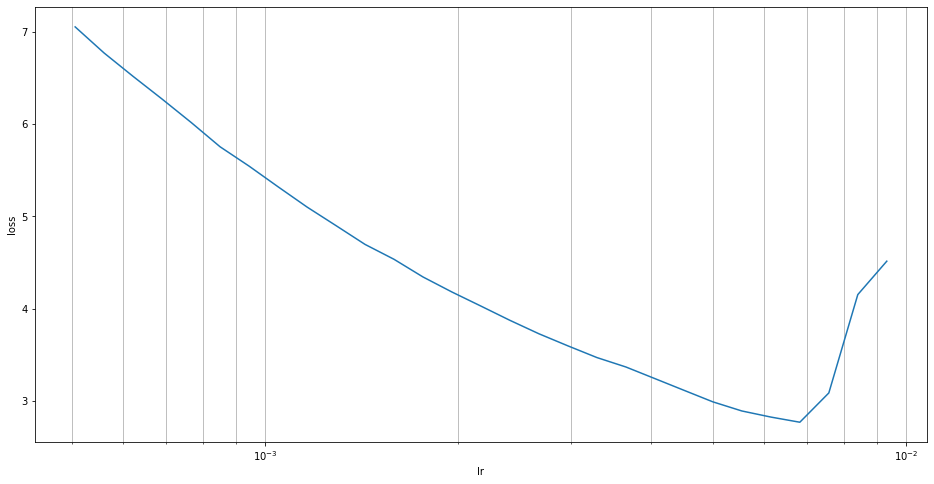

In [20]:
lr_finder.plot()

In [21]:
found_lr = 5e-3
bert.load_state_dict(torch.load("init_params.pth.tar"))
optimizer = torch.optim.Adam(bert.parameters(), lr=found_lr/10)

In [22]:
def loop(net, loader, epoch, is_train):
    net.train(is_train)
    nsp_losses = []
    mlm_losses = []
    total_losses = []

    pbar = tqdm.tqdm(loader, total=len(loader))
    for inp, mlm_lbl, seg_lbl, nsp_lbl in pbar:
        inp, mlm_lbl, seg_lbl, nsp_lbl = inp.to(device), mlm_lbl.to(device), seg_lbl.to(device), nsp_lbl.to(device)
        with torch.set_grad_enabled(is_train):
            nsp_out, mlm_out, _ = net(inp, seg_lbl)
            nsp_loss = loss_fn(nsp_out, nsp_lbl)
            mlm_loss = loss_fn(mlm_out.view(-1, mlm_out.shape[-1]), mlm_lbl.view(-1))
            total_loss = nsp_loss + mlm_loss

            nsp_losses.append(nsp_loss.item())
            mlm_losses.append(mlm_loss.item())
            total_losses.append(total_loss.item())
        if is_train:
            optimizer.zero_grad() # scheduled_optimizer.zero_grad()
            total_loss.backward()
            optimizer.step() # scheduled_optimizer.step_and_update_lr()
        
        pbar.set_description(f"epoch={epoch}, train={int(is_train)}")
        pbar.set_postfix(nsp_loss=f"{np.mean(nsp_losses):.4f}", mlm_loss=f"{np.mean(mlm_losses):.4f}", total_loss=f"{np.mean(total_losses):.4f}")

In [23]:
for epoch in range(n_epochs):
    loop(bert, train_loader, epoch ,True)

epoch=9, train=1: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s, mlm_loss=0.6544, nsp_loss=0.0000, total_loss=0.6544]


In [24]:
# torch.save(bert.state_dict(), "bert_params.pth.tar")

In [25]:
@torch.no_grad()
def predict(net, vocab, sent1, sent2=None, device="cpu"):
    net.eval()
    sent1 = sent1.split()
    if sent2 == None:
        mask_i = sent1.index("<mask>")
    t1 = []
    t2 = []
    if sent2 != None:
        nsp_labels = {0: "not an entailment", 1: "entailment"}
        sent2 = sent2.split()
    for word in sent1:
        t1.append(vocab.stoi.get(word, vocab.stoi["<unk>"]))
    if sent2 != None:
        for word in sent2:
            t2.append(vocab.stoi.get(word, vocab.stoi["<unk>"]))

    t1 = [vocab.stoi["<sos>"]] + t1 + [vocab.stoi["<eos>"]]
    t2 = t2 + [vocab.stoi["<pad>"]]
    inp = (t1 + t2)
    segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])
    inp, segment_label = torch.tensor(inp).unsqueeze(0).to(device), torch.tensor(segment_label).unsqueeze(0).to(device)
    nsp_out, mlm_out, att = net(inp, segment_label)
    if sent2 != None:
        nsp_out = nsp_out.argmax(-1).squeeze(0)
        return nsp_labels[nsp_out.item()], att
    else:
        mlm_out = mlm_out.argmax(-1).squeeze(0)
        masked_tok = mlm_out[mask_i + 1]
        return vocab.itos[masked_tok.item()], att

In [28]:
def plot_attn(attn, h, pred, s1, s2=None, n_rows=3, n_cols=2):
    fig = plt.figure(figsize=(40, 40))
    for i in range(h):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        if s2 != None:
            _attention = attn.squeeze(0)[i, 0:1, :].cpu().detach().numpy()
        else:
            mi = s1.split().index("<mask>")
            _attention = attn.squeeze(0)[i, mi+1:mi+2, :].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=20)

        if s2 != None:
            ax.set_xticklabels(['']+['<sos>']+[i.lower() for i in s1.split()]+['<eos>']+[i.lower() for i in s2.split()]+["<pad>"], rotation=45)
            ax.set_yticklabels(['']+[pred])
        else:
            ax.set_xticklabels(['']+['<sos>']+[i.lower() for i in s1.split()]+['<eos>'], rotation=45)
            ax.set_yticklabels(['']+[pred])

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

entailment torch.Size([1, 6, 12, 12])


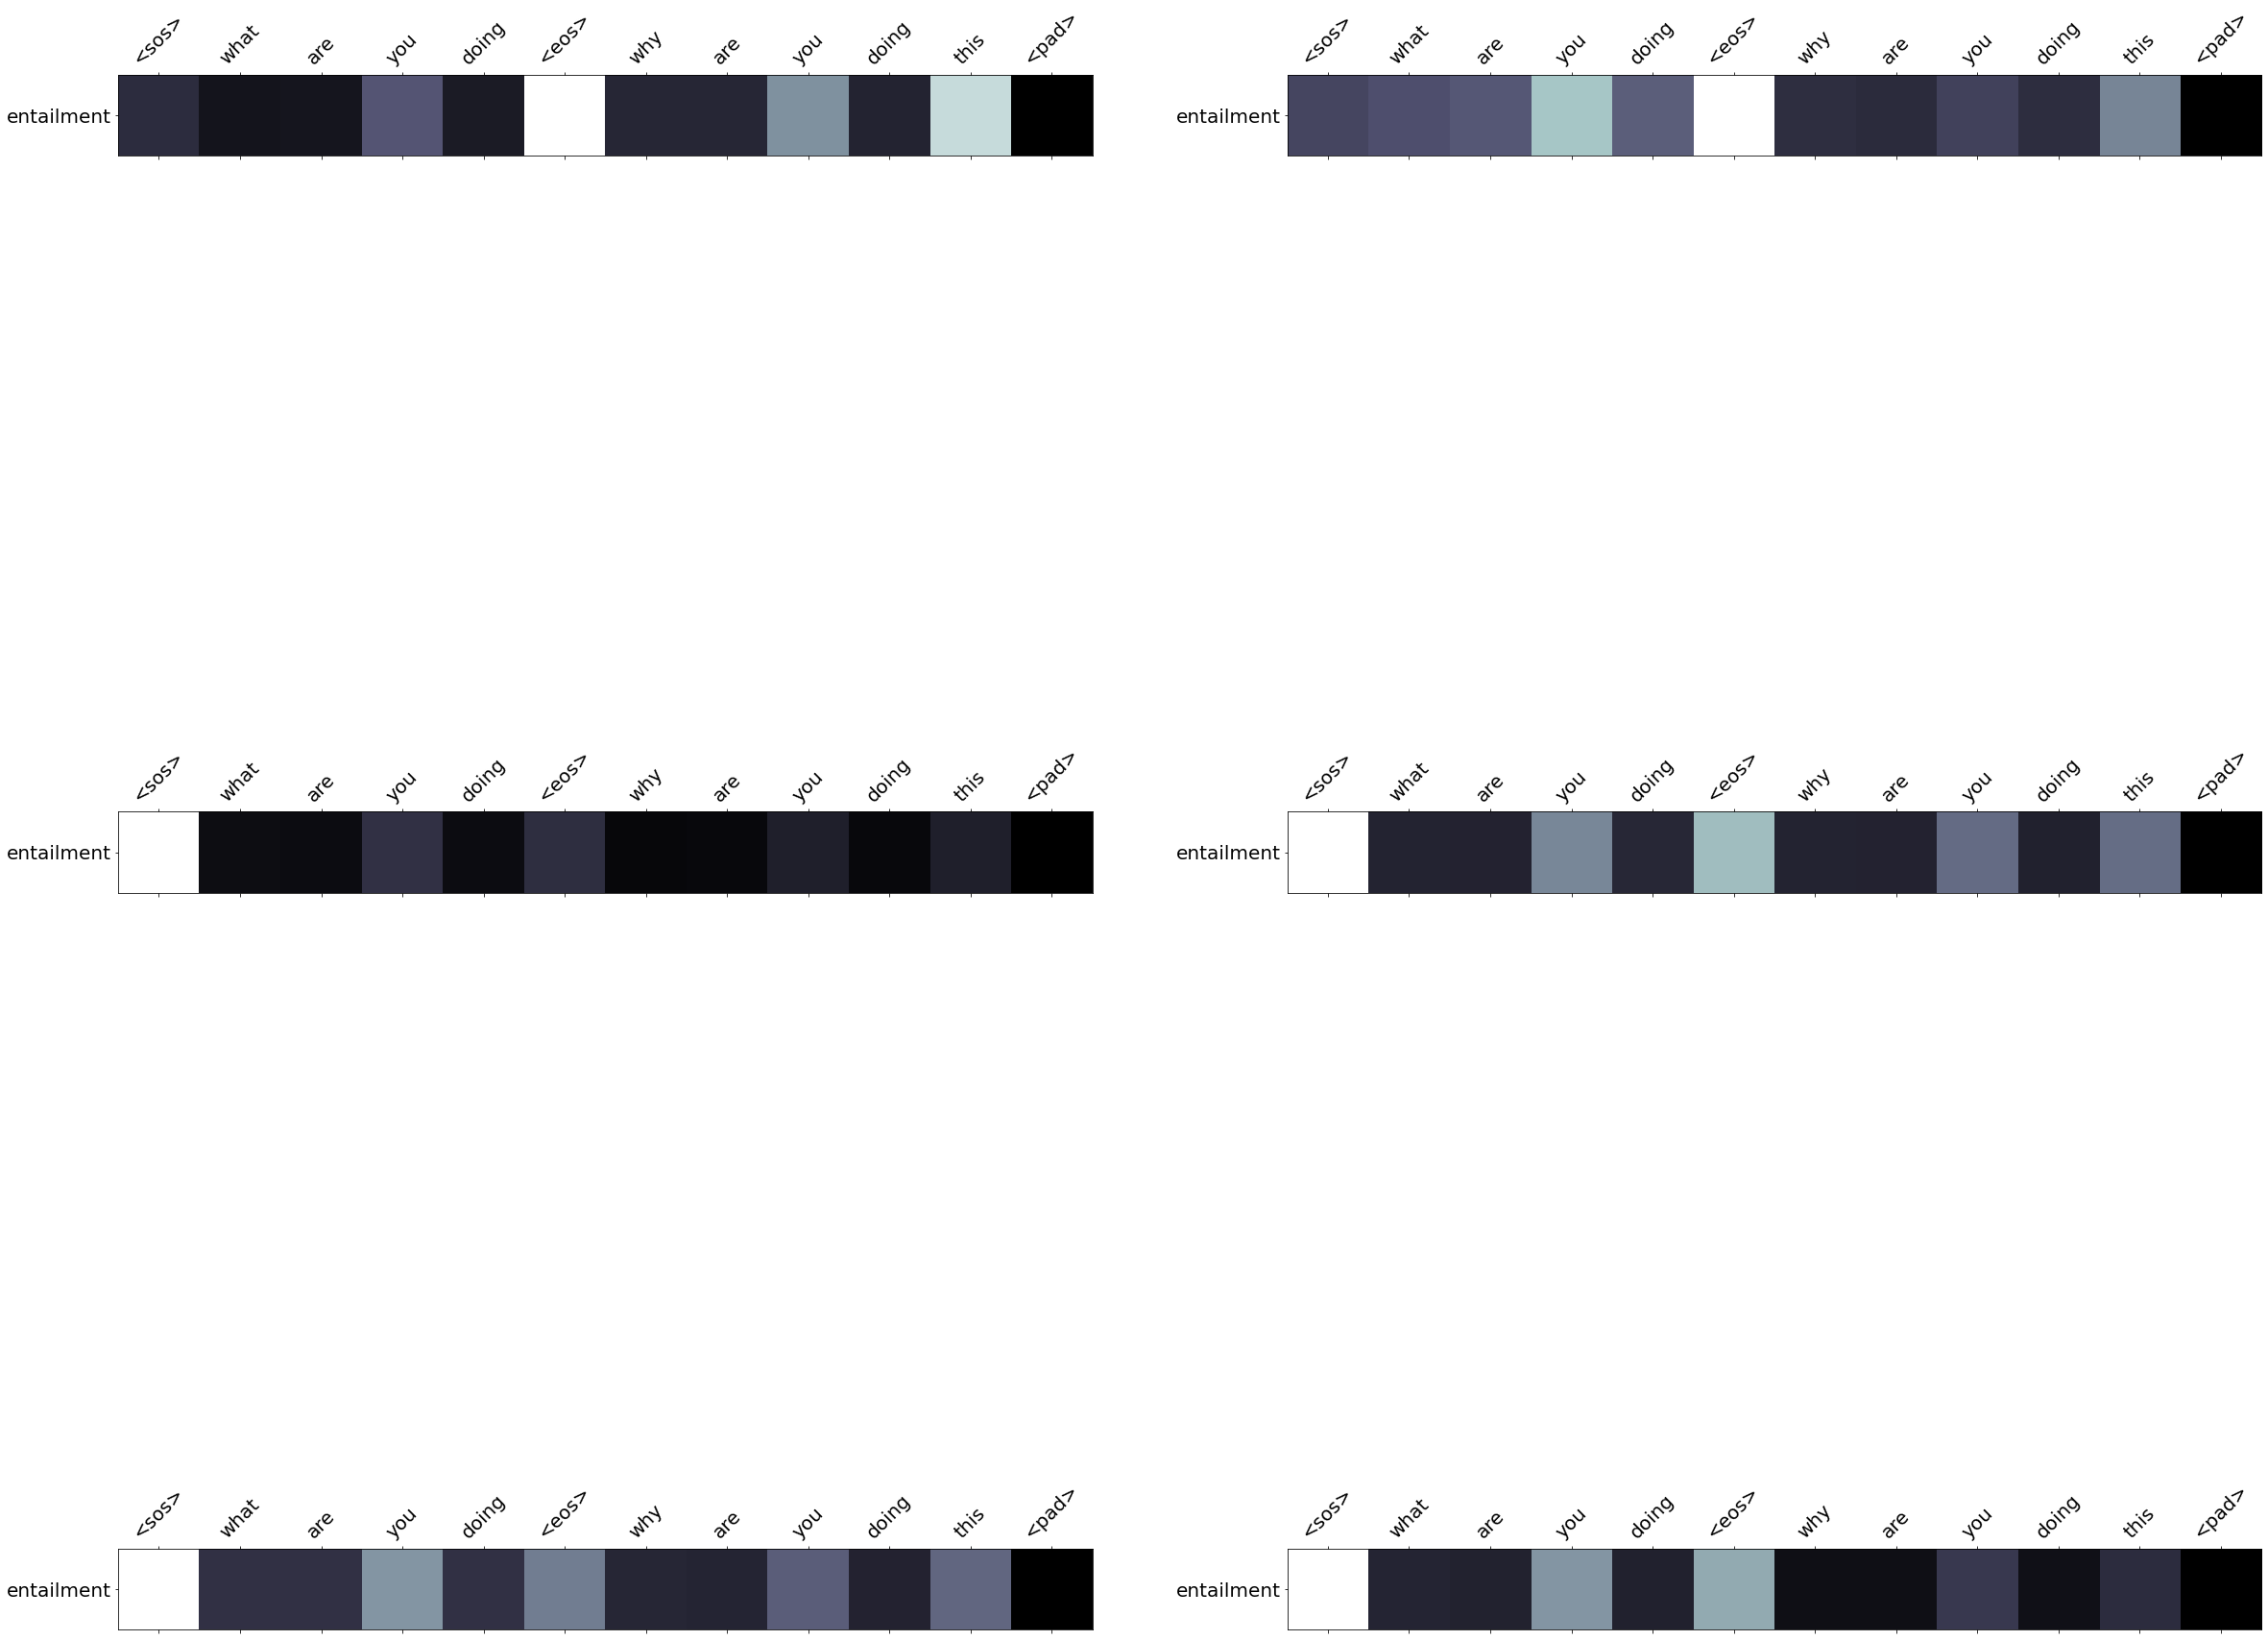

In [29]:
s1 = "what are you doing"
s2 = "why are you doing this"
pred, attn = predict(bert, vocab, s1, s2, device)
print(pred, attn.shape)
plot_attn(attn, h, pred, s1, s2)

entailment


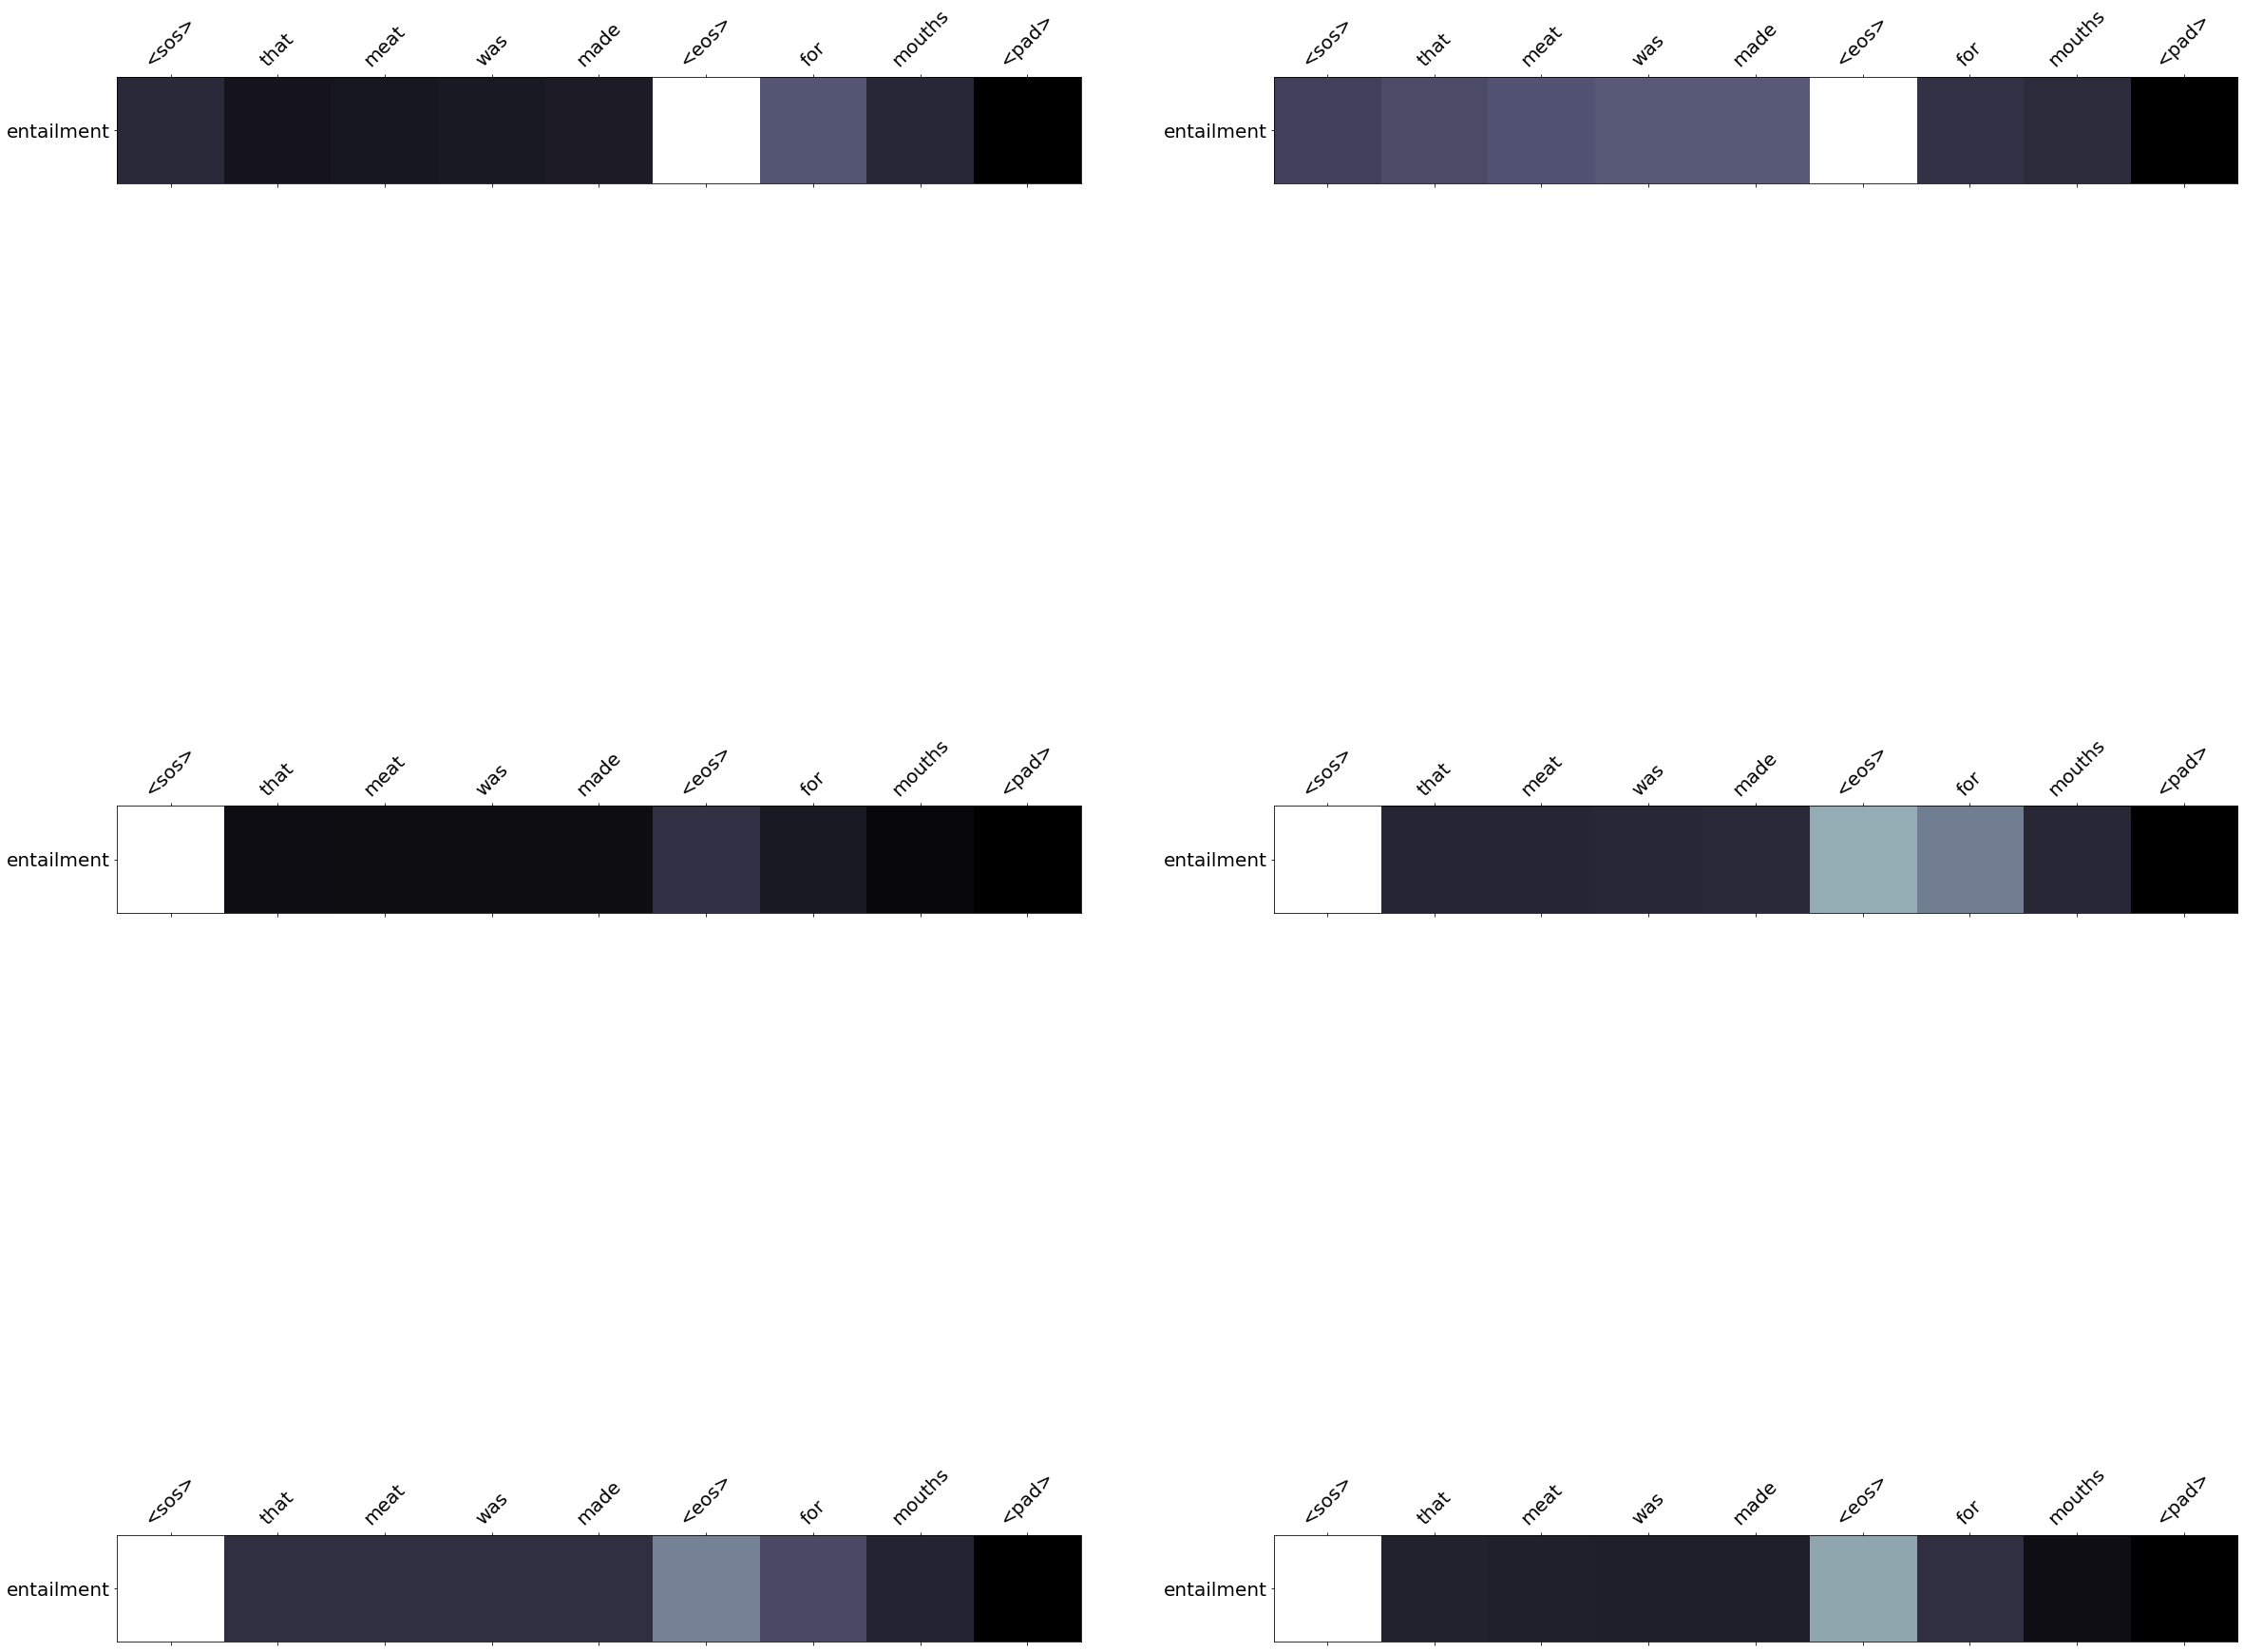

In [30]:
s1 = "That meat was made"
s2 = "for mouths"
pred, attn = predict(bert, vocab, s1, s2, device)
print(pred)
plot_attn(attn, h, pred, s1, s2)

entailment


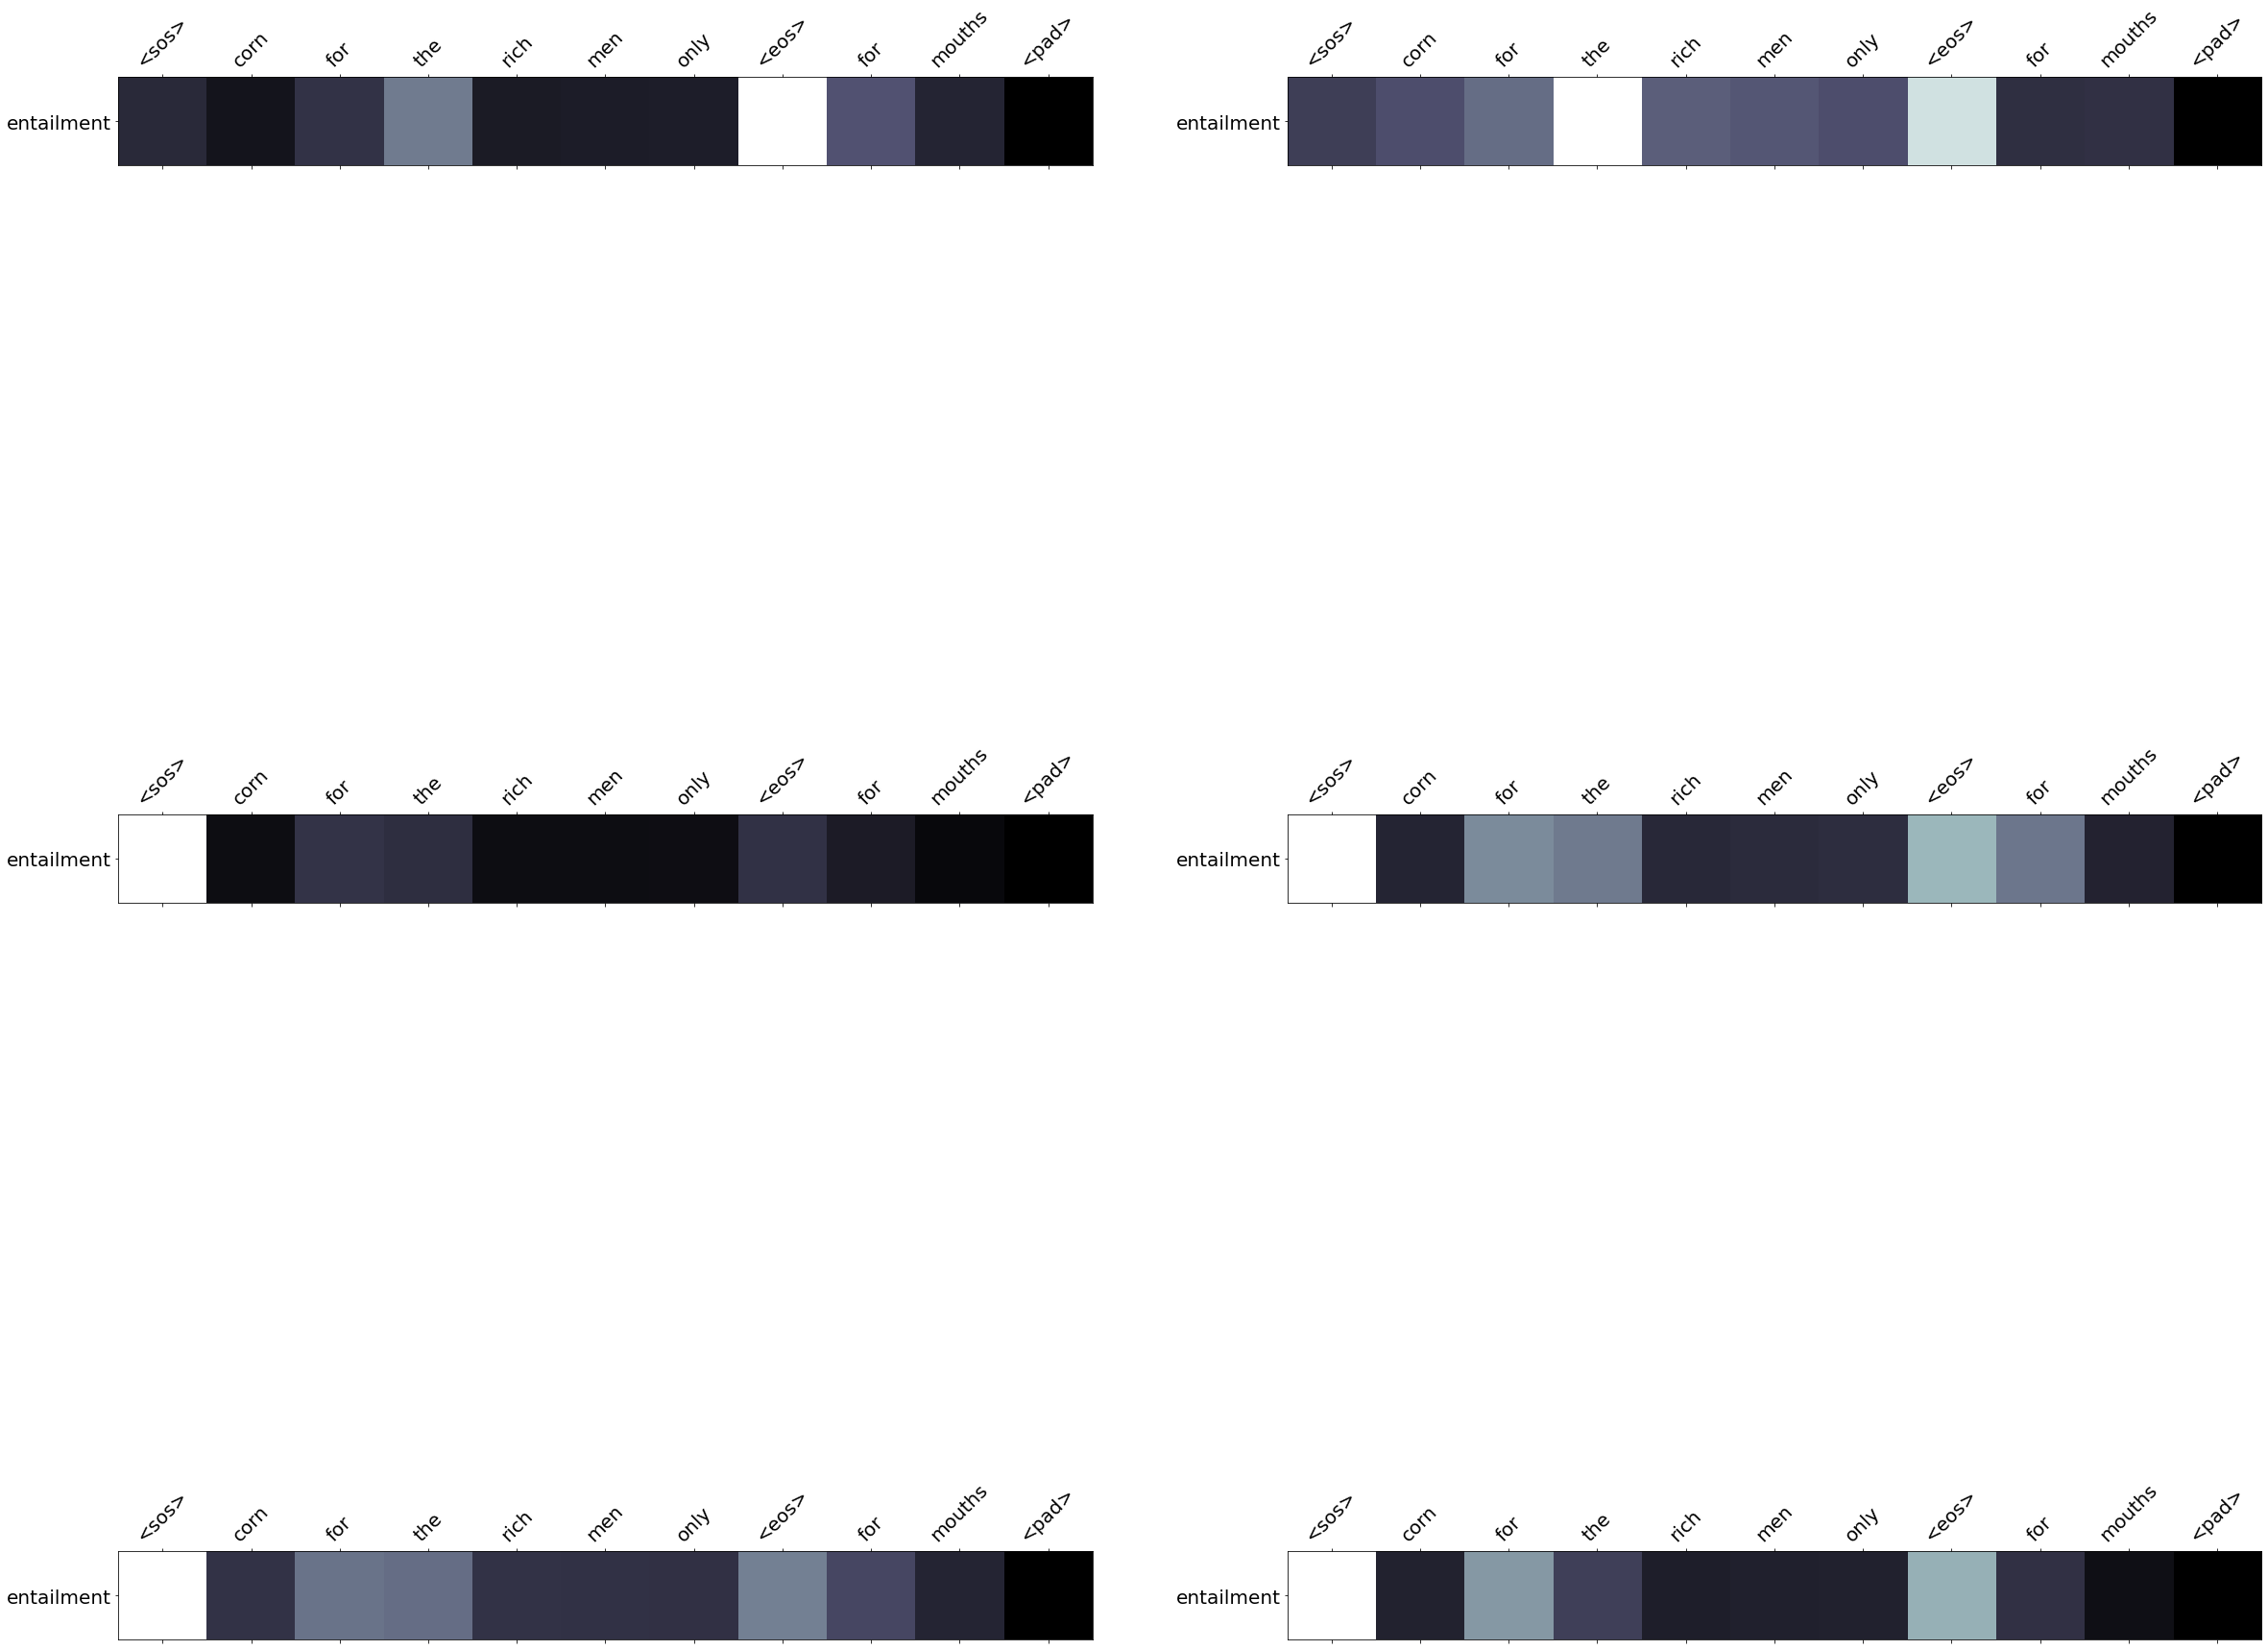

In [31]:
s1 = "Corn for the rich men only"
s2 = "for mouths"
pred, attn = predict(bert, vocab, s1, s2, device)
print(pred)
plot_attn(attn, h, pred, s1, s2)

<unk> torch.Size([1, 6, 9, 9])


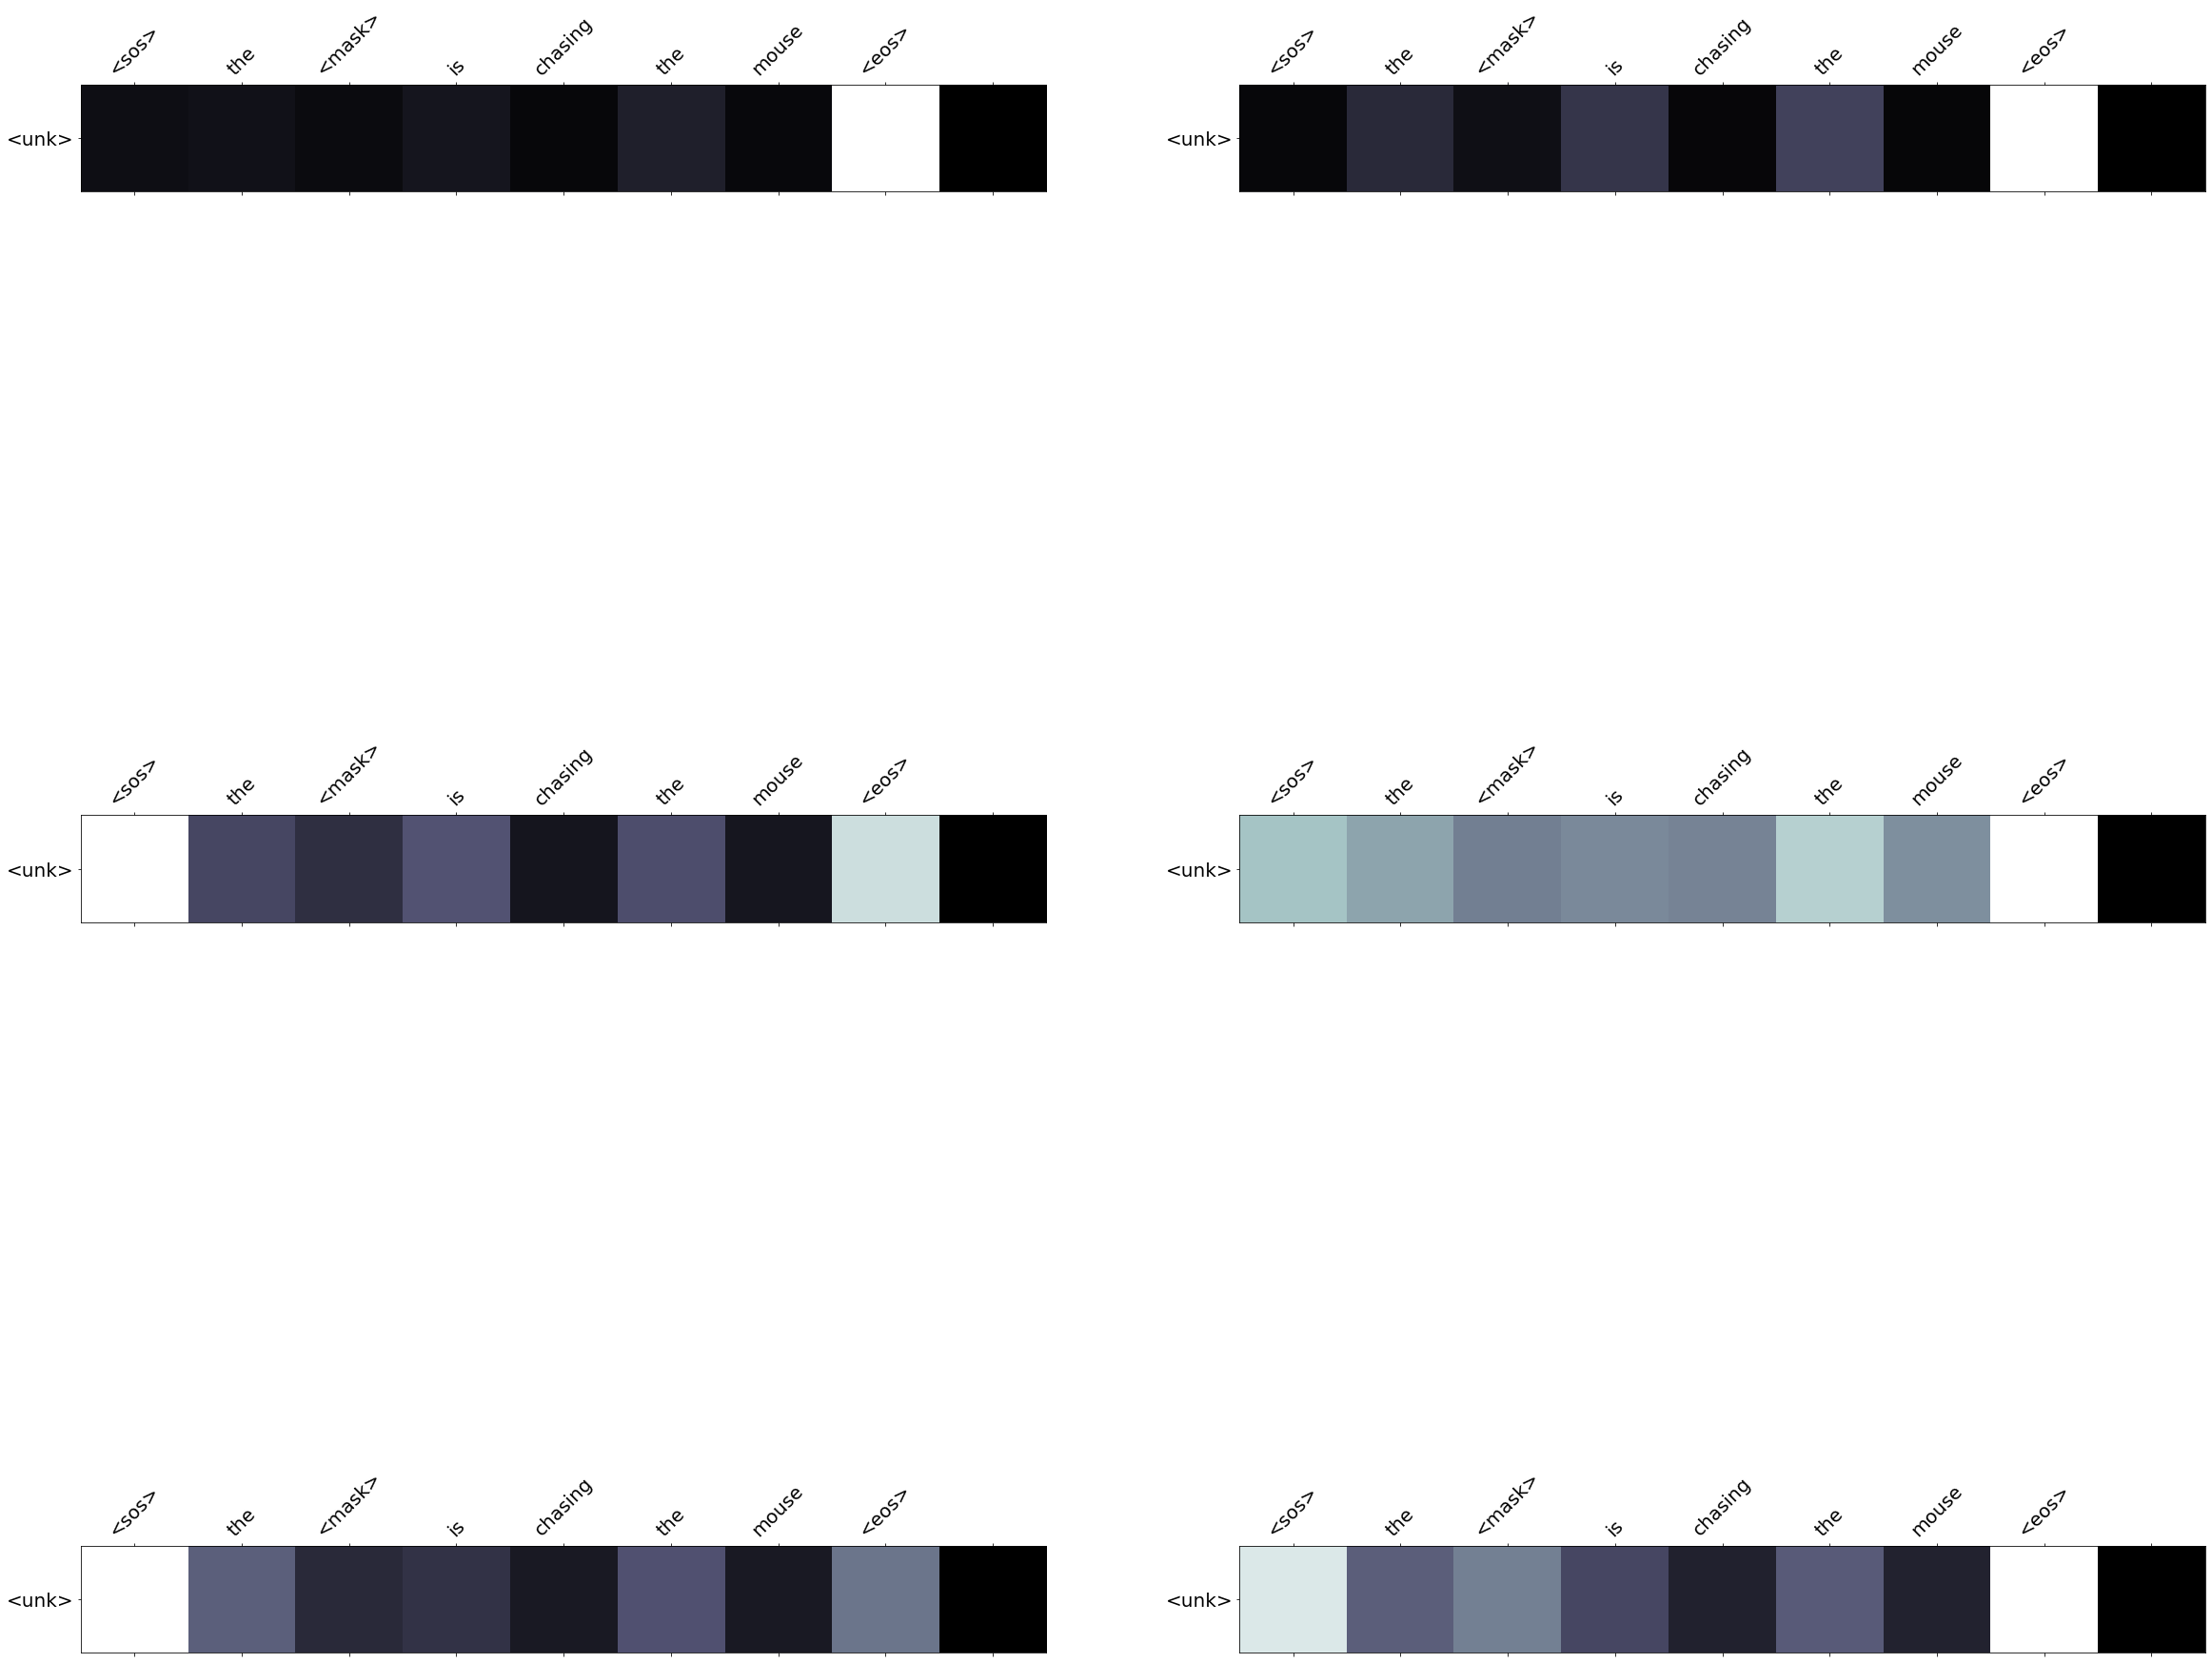

In [32]:
s = "the <mask> is chasing the mouse"
pred, attn = predict(bert, vocab, s, device=device)
print(pred, attn.shape)
plot_attn(attn, h, pred, s)
# this prediction is wrong, a bigger model(bert-base) can solve this problem, but can't train it with just one Tesla T4

<unk> torch.Size([1, 6, 12, 12])


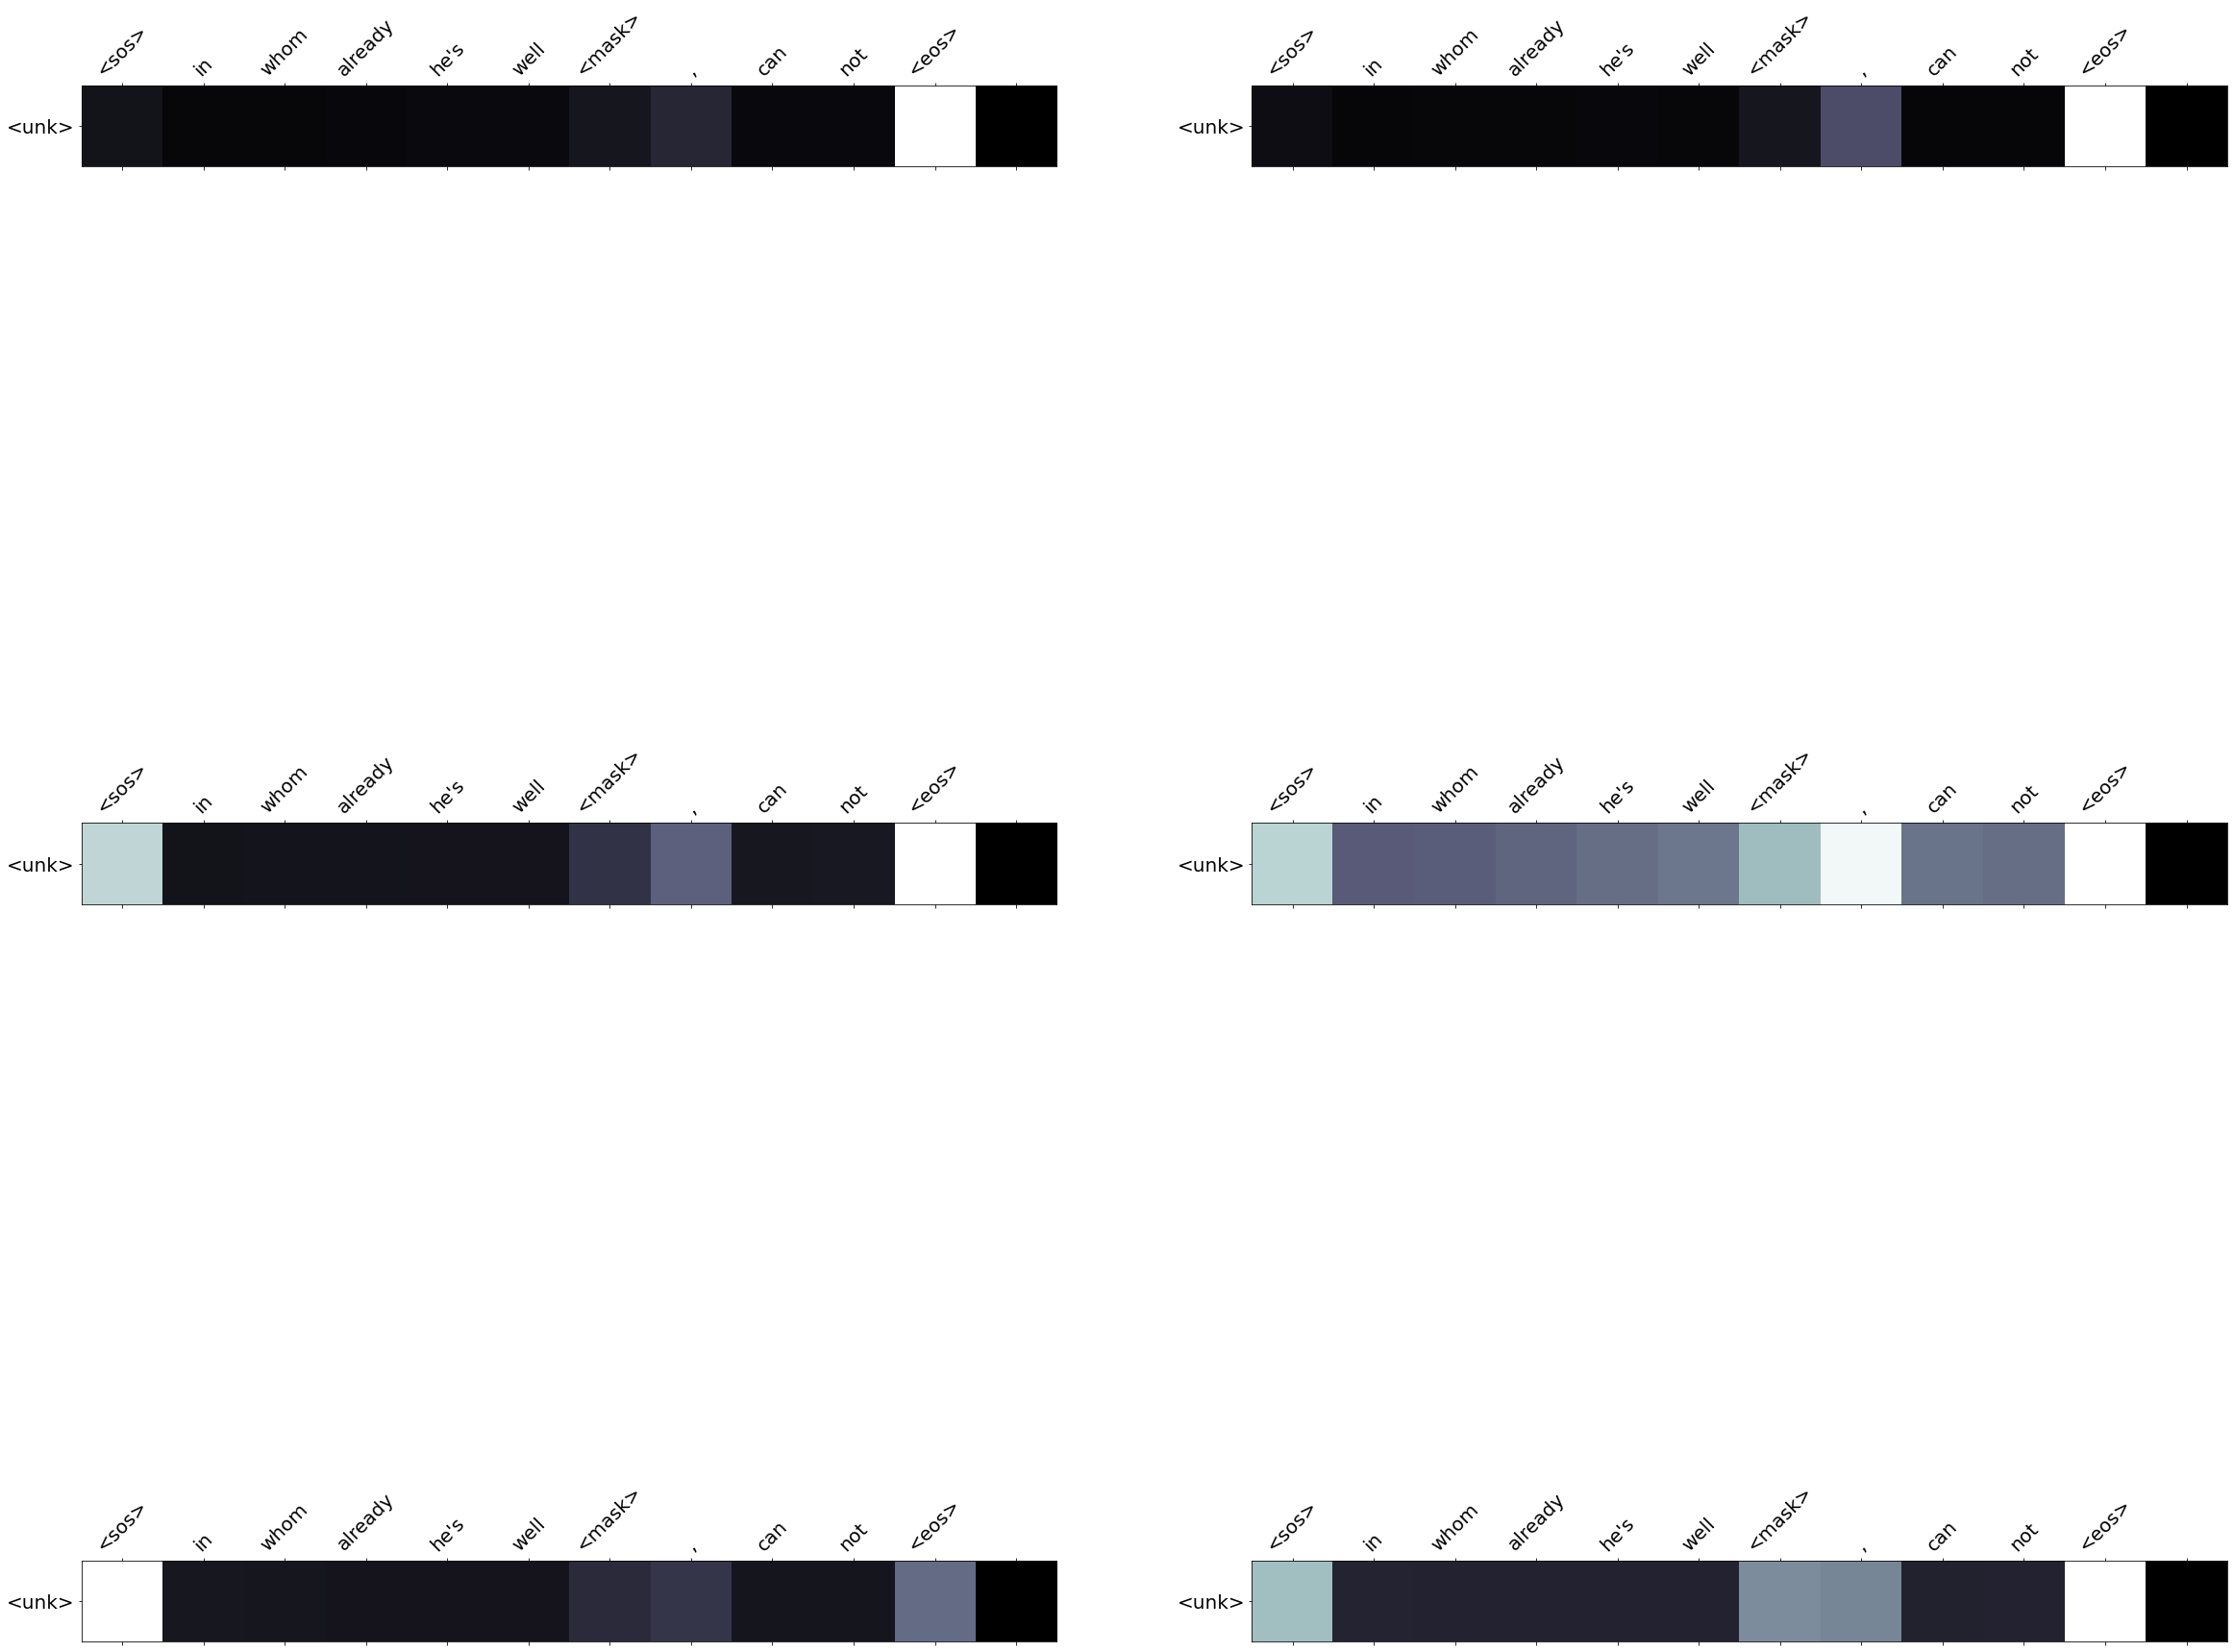

In [35]:
s = "In whom already he's well <mask> , can not" # text from input.txt
pred, attn = predict(bert, vocab, s, device=device)
print(pred, attn.shape)
plot_attn(attn, h, pred, s)
# same problem here